In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

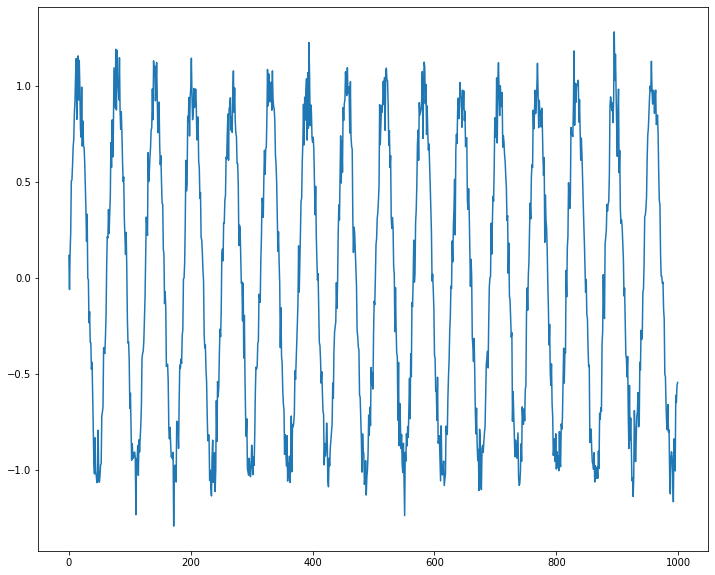

In [2]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.figure(figsize=(12,10))
plt.plot(series)
plt.show()

In [3]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (990, 10), Y.shape: (990, 1)


In [4]:
# Try autoregressive linear model
model = nn.Linear(T,1)

In [5]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2].astype(np.float32))

In [7]:
def full_gd(model, criterion,
            optimizer, X_train,
            y_train, X_test, y_test, epochs=200):
  # stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward paa
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    # backward and optimize
    loss.backward()
    optimizer.step()
    # save losses
    train_losses[it] = loss.item()
    # test loss
    ouputs_test = model(X_test)
    loss_test = criterion(ouputs_test, y_test)
    test_losses[it] = loss_test.item()
    if (it + 1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")
  return train_losses, test_losses

In [8]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.2926, Test Loss: 0.4466
Epoch 10/200, Train Loss: 0.1261, Test Loss: 0.0006
Epoch 15/200, Train Loss: 0.0853, Test Loss: 0.0022
Epoch 20/200, Train Loss: 0.0622, Test Loss: 0.0222
Epoch 25/200, Train Loss: 0.0349, Test Loss: 0.0010
Epoch 30/200, Train Loss: 0.0191, Test Loss: 0.0002
Epoch 35/200, Train Loss: 0.0172, Test Loss: 0.0197
Epoch 40/200, Train Loss: 0.0195, Test Loss: 0.0166
Epoch 45/200, Train Loss: 0.0189, Test Loss: 0.0147
Epoch 50/200, Train Loss: 0.0168, Test Loss: 0.0091
Epoch 55/200, Train Loss: 0.0160, Test Loss: 0.0013
Epoch 60/200, Train Loss: 0.0158, Test Loss: 0.0020
Epoch 65/200, Train Loss: 0.0153, Test Loss: 0.0018
Epoch 70/200, Train Loss: 0.0149, Test Loss: 0.0035
Epoch 75/200, Train Loss: 0.0148, Test Loss: 0.0050
Epoch 80/200, Train Loss: 0.0146, Test Loss: 0.0033
Epoch 85/200, Train Loss: 0.0145, Test Loss: 0.0031
Epoch 90/200, Train Loss: 0.0144, Test Loss: 0.0016
Epoch 95/200, Train Loss: 0.0143, Test Loss: 0.0019
Epoch 100/200

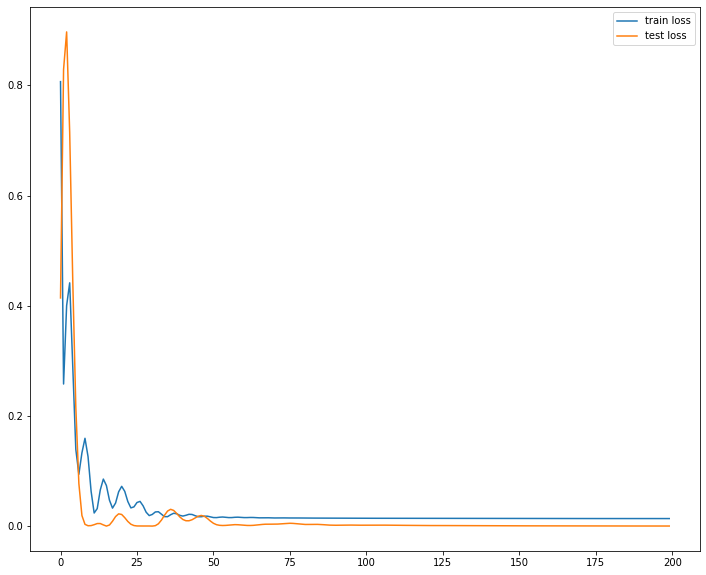

In [9]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [10]:
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []
# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))
while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1,-1)
  p = model(input_) # [0,0] 1x1 array -> scalar
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

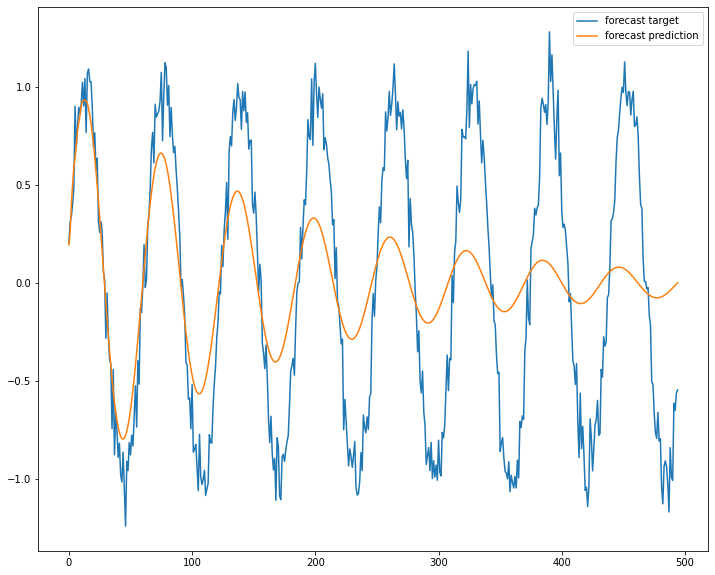

In [11]:
plt.figure(figsize=(12,10))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()